# Car traffic and parking density modeling from Uber travel time data

---

##  Overview

1. Introduction
2. Data preparation
3. Stochastic distributions
4. Sampling
5. Normalization

---

## 1 Introduction

We are given the arithmetic mean of hourly travel time measurements between different zones of a city and want to estimate the traffic flow and spatial parking distribution of cars in that city. We start with preparing the original datasets that we retrieve from Uber (Data preparation). In a first stage of the analysis, we estimate the probabilities of car traffic between zones as a function of mean travel times. These probabilities exploit the changes in mean travel time between the zones of the city throughout a day to approximate information about a) when cars would drive and b) where they would drive to (Stochastic distributions). In a second stage, we sample individual car traffic from these probability distributions and determine the number of cars parked in every zone as a function of cars driving from one zone to another (Sampling). In a third and last stage, we use the results to correct the probability distributions of traffic flow we initially sampled from (Normalization).

<img src="Figures/MethodFigure.png">

---

## 2. Data preparation 
In this section, we create two matrices called **"distance_matrix_km"** and **"data_matrix"** from the original Uber Movement datasets. The distance_matrix_km contains the average beeline distance between every two zones of the city in kilometers (km). The data_matrix contains the mean travel times from origin zones to destination zones and their standard deviation measured during a particular quarter of the year for each hour of the day. It has sparsity wherever the number of undertaken Uber rides were zero or not large enough to represent overall traffic.

### 2.1  Importing geographic data from a GeoJSON file (Example: Boston)
Each zone of the city is given as a polygon with multiple pairs of latitudinal and longitudinal coordinates. The data of these vertices is given as a JSON file. We import the JSON file and save the coordinates of each zone of the city separately in two matrices called **"longitude_matrix"** and **"latitude_matrix"**. The coordinates for each polygon are nested and unregularly split at different branches of the file. Extracting the data therefore requires a slightly more sophisticated code than in the case of an unsplit or regularly branched JSON file. 

In [1]:
#We import a number of packages we want to use throughout the notebook session here. 
using Pkg         
Pkg.update()
Pkg.add("PyPlot")
Pkg.add("CSV")
Pkg.add("Distributions")
Pkg.add("JSON")
Pkg.add("JLD2")
using PyPlot
using CSV
using Distributions
using JSON
using JLD2

path_to_json_data = "/data/Uber Movement/Boston/boston_censustracts.json"

import JSON
open(path_to_json_data, "r") do json_file 
    global julia_file
    julia_file = JSON.parse(json_file);
end

a = julia_file["features"]
first_zone_id = parse(Int,a[1]["properties"]["MOVEMENT_ID"]);
if (first_zone_id == 0) # catches the case that the first zone ID is a zero
    number_zones = parse(Int,a[length(a)]["properties"]["MOVEMENT_ID"]) + 1;
else
    number_zones =  parse(Int,a[length(a)]["properties"]["MOVEMENT_ID"]);
end
longitude_matrix = zeros(number_zones, 10000); # 
latitude_matrix = zeros(number_zones, 10000);

for i=1:length(a)
    entry = a[i];
    id = parse(Int,entry["properties"]["MOVEMENT_ID"]);
    if (id == 0) # catches the case that the first zone ID is a zero
        id = number_zones;
    end
    coordinates = entry["geometry"]["coordinates"];
    counter = 0;
    
    if(typeof(coordinates) == Float64)
        counter = counter + 1;
        longitude_matrix[id, counter] = coordinates[1];
        latitude_matrix[id, counter] = coordinates[2];
    else
        for j=1:length(coordinates)
            nested_coordinates = coordinates[j]
            if(typeof(nested_coordinates) == Float64)
                counter = counter + 1;
                longitude_matrix[id, counter] = coordinates[1];
                latitude_matrix[id, counter] = coordinates[2];
            else
                for k=1:length(nested_coordinates)
                    nested_coordinates = coordinates[j][k];
                    if(typeof(nested_coordinates) == Float64)
                        counter = counter + 1;
                        longitude_matrix[id, counter] = coordinates[j][1];
                        latitude_matrix[id, counter] = coordinates[j][2];
                    else
                        for l=1:length(nested_coordinates)
                            nested_coordinates = coordinates[j][k][l];
                            if(typeof(nested_coordinates) == Float64)
                                counter = counter + 1;
                                longitude_matrix[id, counter] = coordinates[j][k][1];
                                latitude_matrix[id, counter] = coordinates[j][k][2];
                            else
                                for m=1:length(nested_coordinates)
                                    nested_coordinates = coordinates[j][k][l][m];
                                    if(typeof(nested_coordinates) == Float64)
                                        counter = counter + 1;
                                        longitude_matrix[id, counter] = coordinates[j][k][l][1];
                                        latitude_matrix[id, counter] = coordinates[j][k][l][2];
                                    else
                                        for n=1:length(nested_coordinates)
                                            nested_coordinates = coordinates[j][k][l][m][n];
                                            if(typeof(nested_coordinates) == Float64)
                                                counter = counter + 1;
                                                longitude_matrix[id, counter] = coordinates[j][k][l][m][1];
                                                latitude_matrix[id, counter] = coordinates[j][k][l][m][2];
                                            else
                                                for o=1:length(nested_coordinates)
                                                    nested_coordinates = coordinates[j][k][l][m][n][o];
                                                    if(typeof(coordinates) == Float64)
                                                        counter = counter + 1;
                                                        longitude_matrix[id, counter] = coordinates[j][k][l][m][n][1];
                                                        latitude_matrix[id, counter] = coordinates[j][k][l][m][n][2];
                                                    else
                                                        println("Double-check how often this json file is nested at:")
                                                        println("i = ", i)
                                                        println("j = ", j)
                                                        println("k = ", k)
                                                        println("l = ", l)
                                                        println("m = ", m)
                                                        println("n = ", n)
                                                        println("o = ", o)
                                                    end
                                                end
                                            end
                                        end
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
    end
end

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.to

### 2.2 Averaging geographic coordinates for each zone

Now we determine the arithmetic mean of the latitude and longitude coordinates for each zone. These values are stored in the arrays **"average_long"** and **"average_lat"** respectively. Note that the calculated point can lay outside the polygon if the polygon is not convex. Alternatively, modelers can calculate the geometric centers (also called centroids or centres of gravity) of the polygons. 

In [2]:
average_lat = zeros(number_zones,1);
average_long = zeros(number_zones,1);
for i=1:number_zones
    counter = 0;
    summing_lat = 0;
    summing_long = 0;
    for j=1:10000
        if(longitude_matrix[i,j] == 0)
            break;
        else
            counter = counter + 1;
            summing_lat = summing_lat + latitude_matrix[i,j];
            summing_long = summing_long + longitude_matrix[i,j];
        end
    end
    average_lat[i, 1] = summing_lat / counter;
    average_long[i, 1] = summing_long / counter;
end

### 2.3 Calculating distances between each zone
We calculate the distance between two zones as the beeline length between the average coordinates of their polygons, and save these in **"distance_matrix_km"**. The easiest way to calculate distances between two points on the planet is to assume that latitudes and longitudes are straight lines. This is a good approximation for short distances only, such as given for regions within a small city. If we use a constant distance of 111.3 km between each latitudinal degree and an average distance of 71.5 km per longitudinal degree, we can simply calculate the distances with the pythagorean theorem. A more accurate way of doing this is to consider that longitudinal lines are not straight but rather depend on the latitudinal position: the distance between two longitudinal lines is somewhat around 111.3 km at the equator and 0 at the north and south poles. The depencende on the latitudinal position "lat" can then be expressed as:

$111.3 km \cdotp cos(lat)$

If we replace the average distance of 71.5 km per longitudinal degree with this expression within the pythagorean theorem, we can calculate the distance d<sub>ij</sub> between two points P<sub>i</sub> (lat<sub>i</sub> | long<sub>i</sub>) and P<sub>j</sub> (lat<sub>j</sub> | long<sub>j</sub>), with $i,j = 1...N$, $i ≠ j$ as:

d<sub>ij</sub> = d<sub>ji</sub> := $111.3 km \cdotp \sqrt{cos^2(\frac{lat_{i}+lat_{j}}{2}) \cdotp (long_{i}-long_{j})^2 + (lat_{i}-lat_{j})^2}$

In [3]:
c_lat_long = 111.3;
conv_deg_rad = 0.01745; # this is a constant for the conversion from degrees into radians.
distance_matrix_km = zeros(number_zones, number_zones);

for i=1:(number_zones-1)
    long1 = average_long[i];
    lat1 = average_lat[i];
    for j=i:number_zones
        long2 = average_long[j];
        lat2 = average_lat[j];
        distance_km = c_lat_long * sqrt((cos((lat1+lat2)/2 * conv_deg_rad))^2 * (long1-long2)^2 + (lat1-lat2)^2);
        distance_matrix_km[i,j] = distance_km;
        distance_matrix_km[j,i] = distance_km;
    end 
end

### 2.4 Importing traffic data from a CSV file (Example: Boston on weekdays in first quarter of 2016)
We import and store the raw data into a variable that we call **"rawdata"**. The table below shows the entries and their types. The abbreviation "hod" stands for hour of day and "dstid" for the destination zone ID. The headers Int64 and Float64 stand for the variable types of 64-bit Integer and 64-bit Float respectively. The imported matrix "raw_data" contains the following four original entry types for all $t = 1...T$ and $i,j = 1...N$, with $i ≠ j$:

* m<sub>ij,t</sub> = the mean travel time from zone i to zone j at daytime t
* $\sigma$<sub>ij,t</sub> = the standard deviation of travel time from zone i to zone j at daytime t
* geo_m<sub>ij,t</sub> := the geometric mean travel time from zone i to zone j at daytime t
* geo_$\sigma$<sub>ij,t</sub> := the geometric standard deviation of travel time from zone i to zone j at daytime t 

In [4]:
rawdata = CSV.read("/data/Uber movement/Boston/boston-censustracts-2016-1-OnlyWeekdays-HourlyAggregate.csv")

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,3,5,7,962.0,260.9,924.86,1.33
2,5,3,19,1119.64,317.23,1078.79,1.31
3,1,12,14,246.82,175.48,195.65,1.97
4,1,12,23,197.59,177.86,149.88,2.02
5,3,21,6,755.63,299.2,706.48,1.43
6,3,21,15,1245.19,852.79,1038.64,1.78
7,3,27,0,569.0,269.88,519.57,1.5
8,4,17,0,632.83,256.91,592.66,1.41
9,4,17,9,685.81,178.6,668.03,1.24


### 2.5 Aggregating traffic data in a new matrix
We create a new matrix called **"datamatrix"** with zeros as initial entries in the desired dimension of N x N x T x 2. The first N = 1,247 stands for the travel zone of origin, the second N = 1,247 for the travel zone of destination, the T = 24 for each hour of the day (hourly time resolution) and the 2 for each relevant entry of the distribution (m<sub>ij,t</sub> and $\sigma$<sub>ij,t</sub>). Next, we insert the provided data from "rawdata" into datamatrix, without the geometric entries as we will only use m<sub>ij,t</sub> and $\sigma$<sub>ij,t</sub>. 

In [5]:
size_rawdata, placeholder_columns = size(rawdata); # Determine number of rows in dataset 
T = 24; # Time resolution. 24 stands for hourly resolution as a day is divided into 24 discrete time steps.
datamatrix = zeros(number_zones, number_zones, T, 2);

for i=1:size_rawdata
    if(rawdata[i,1] == 0)
        rawdata[i,1] = number_zones; # in case a zone has an ID of "0", we give it a new zone ID. 
    end
    if(rawdata[i,2] == 0)
        rawdata[i,2] = number_zones; # in case a zone has an ID of "0", we give it a new zone ID. 
    end
    if(rawdata[i,3] == 0)
        rawdata[i,3] = 24; # Midnight is denoted by a value of zero. We replace it with 24 to get matrix indexes right.
    end
    datamatrix[rawdata[i,1],rawdata[i,2],rawdata[i,3],1] = rawdata[i,4]; # mean_travel_time goes here
    datamatrix[rawdata[i,1],rawdata[i,2],rawdata[i,3],2] = rawdata[i,5]; # standard_deviation_travel_time goes here
end

### 2.6 The sparsity of data

The datasets we use entail some degree of sparsity. We use the share of available data pairs compared to the maximum number of possible measurements as an index for the density of the given dataset. The index shall hence assume a value between 0 and 1. The higher the density of data, the better we expect the outcome of our sampling method. We define:

* $Av$ := available number of mean travel time entries in "rawdata"
* $Ma$ := N $\cdot$ (N − 1) $\cdot$  T := maximum number of possible measurements in "datamatrix"
* $De$ := $\frac{Av}{Ma}$ := density of data
* $Sp$ := 1 - $De$ := sparsity of data

In [6]:
Av = length(rawdata[:,1])
Ma = number_zones * (number_zones-1) * T;
De = Av/Ma;
Sp = 100 * (1 - De);
Sp = round.(Int,Sp);
println("The sparsity of the imported dataset \"rawdata\" is Sp = ", Sp,"%")

The sparsity of the imported dataset "rawdata" is Sp = 94%


### 2.7 Reducing the sparsity of data

Further research can improve the outcome of the subsequent sampling method by estimating the missing travel time entries and their standard deviations. This would reduce the sparsity of "data_matrix" and deliver more accurate sampling results. We suggest two ways for doing this: A first way could be to fill the data gaps with measurements retrieved from e.g. Google Maps Application Programming Interfaces (APIs). A second way could be to estimate (or "predict") the missing entries with supervised machine learning. The location and sizes of the city zones could be some of the main features for implementing learning. A more advanced approach would be to include satelite images of the city zones and use (deep) Artificial Neural Networks (ANN) to learn further features that determine travel time changes in addition to the location and size of city zones. With this method, one could then validate the outcome of the estimation (or "prediction") from e.g. Google Maps APIs or on a subset of the same Uber data to ensure realistic results. 


---

## 3 Stochastic distributions
In this section, we create two probability matrices called **"p_drive"** and **"p_dest"**. The first matrix p_drive contains approximations of travel activity, dependent on an origin zone and the time of the day. The second matrix p_dest contains approximations of how popular destination zones are, dependent on an origin zone of a car and the time of the day.


### 3.1 Driving activity
In each simulation time step, we need to decide whether a car drives to another zone or stays parked in the same zone. For this purpose, we derive a probabilistic distribution from the sum of mean travel times out of each zone. We use this sum as an indicator of travel activity. We compare the sum of mean travel time out of every zone in each time step with the minimum and maximum sums of mean travel time out of the same zone throughout all T = 24 time steps of the day. In each time step and for each zone, a (possibly) linear function then assigns a value between 0 and 1 (probability) of driving according to the minimum and maximum sums of mean travel time out of the respective zone. We introduce two parameters for determining the range of driving probability, given the minimum and maximum sums of mean travel time:

* p_min := the probability that a car will drive, given the minimum sum of mean travel time out of a zone
* p_max := the probability that a car will drive, given the maximum sum of mean travel time out of a zone

We first assume that a car will drive with a p_min = 10% probability, given the minimum, and with a p_max = 90% probability given the maximum sum of mean travel time. The range of 10% till 90% is now chosen arbitrarily, and will be improved in a normalization process in which we tune p_min and p_max so as to approach more realistic values of overall travel time during the lifetime of a vehicle. If the sum of travel time out of a city is zero, we exceptionally assume that traffic in this zone is very low and set the proability that a car travels to 0%. We save the probability entries in a T X N matrix called **"p_drive"**. If we determine all entries of p_drive, we should have a Binomial probability distribution for each zone and each time step of the day. This equals to 24 $\cdotp$ 1,247 = 29,928 distributions or single probabilities for our example of Boston. The probability of parking is always one minus the probability of driving and must therefore not be saved explicitly. 


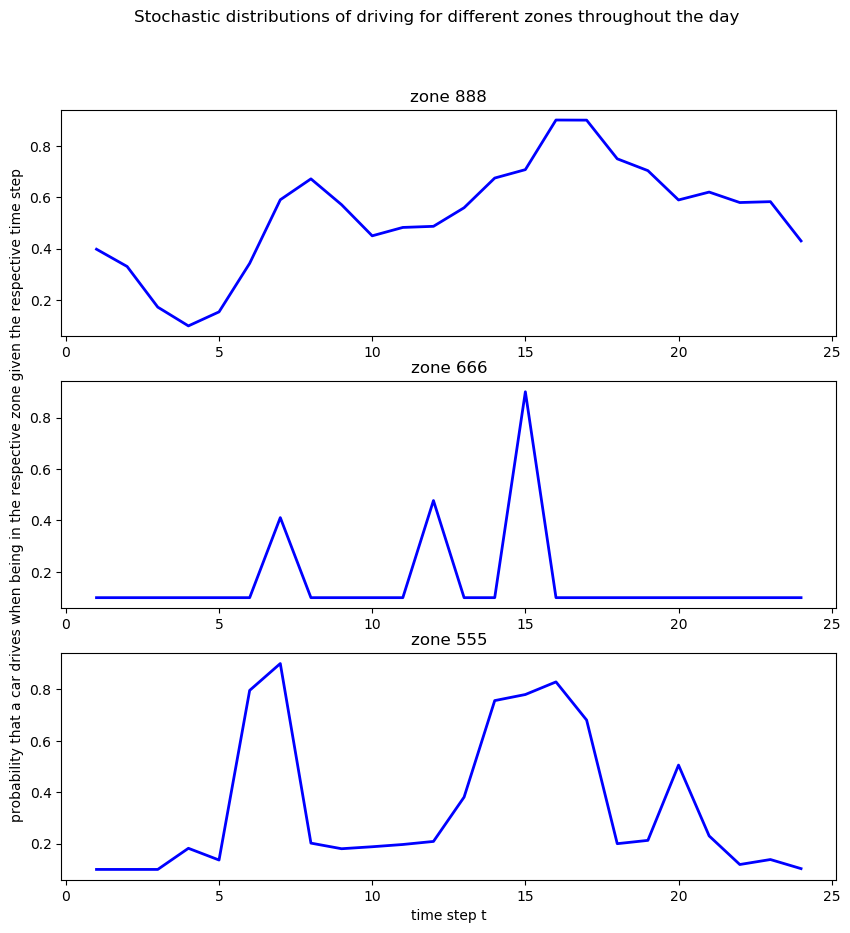

In [7]:
p_min = 0.1;
p_max = 0.9;
e = 1; # An exponent that determines the dynamics of driving activity. Can be changed.

p_drive = zeros(number_zones, T);
mean_sum = zeros(number_zones, T);
min_t = zeros(number_zones,1);
max_t = zeros(number_zones,1);

# Calculating the sums, minimum sums and maximum sums of mean travel time out of a zone
for i=1:number_zones    
    for t=1:T
        mean_sum[i, t] = sum(datamatrix[i,:,t,1]);
    end
    max_t[i] = maximum(mean_sum[i,:]);
    min_t[i] = minimum(mean_sum[i,:]);
end

# Calculating the Bernoulli distributions p_drive
for i=1:number_zones
    if(max_t[i] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
        for t=1:T
            # A linear function for assigning a value of 10% to p_drive if min_t is given, and a value of 90% if max_t is given.
            p_drive[i,t] = p_min + (p_max - p_min) * ((mean_sum[i,t] - min_t[i]) / (max_t[i] - min_t[i]))^e;  
        end
    end
end

# Visualizing exemplar stochastic distributions for zones 888, 666 and 555
fig = figure(figsize=(10,10))
x = 1:24;

subplot(311)
y = p_drive[888, :];
plot(x, y, color="blue", linewidth=2.0);
title("zone 888");

subplot(312)
y = p_drive[666, :];
plot(x, y, color="blue", linewidth=2.0);
ylabel("probability that a car drives when being in the respective zone given the respective time step");
title("zone 666");

subplot(313)
y = p_drive[555, :];
plot(x, y, color="blue", linewidth=2.0);
title("zone 555");

suptitle("Stochastic distributions of driving for different zones throughout the day");
xlabel("time step t");

### 3.2 Popularity of destinations
When creating a stochastic distribution for sampling the travel destinations, we ask ourselves how likely it is that a car in zone i travels to zone j at a given point t in time. We start with comparing the mean travel times from any zone i (origin) to any other zone j (destination) at any time step t $\in$ [1,...,24] of the day with the highest and lowest mean travel time out of all time steps t = 1...T for the same origin-destination pair. Given that, we have an indicator of how "popular" a destination zone at that given time is, compared to other times of the day. We hence view an increased travel time to a certain destination at a given time as a hint that **relatively** many cars will travel into this destination zone. Given this logic, we naturally have inacurracies in the determined distributions: increased traffic and hence longer mean travel times can be caused due to overloaded capacities of roads **between** the origin and destination zones. We save the probabilities in a N X N X T matrix called p_dest. If we determine all entries of p_dest, we should have a Multinomial distribution for each zone and each time step of the day. This equals to 1,247 $\cdotp$ 24 = 29,928 distributions, or 1,247 $\cdotp$ 1,247 $\cdotp$ 24 = 37,320,216 single probabilities for our example of Boston. Note that a can also travel to a destination within its origin zone.

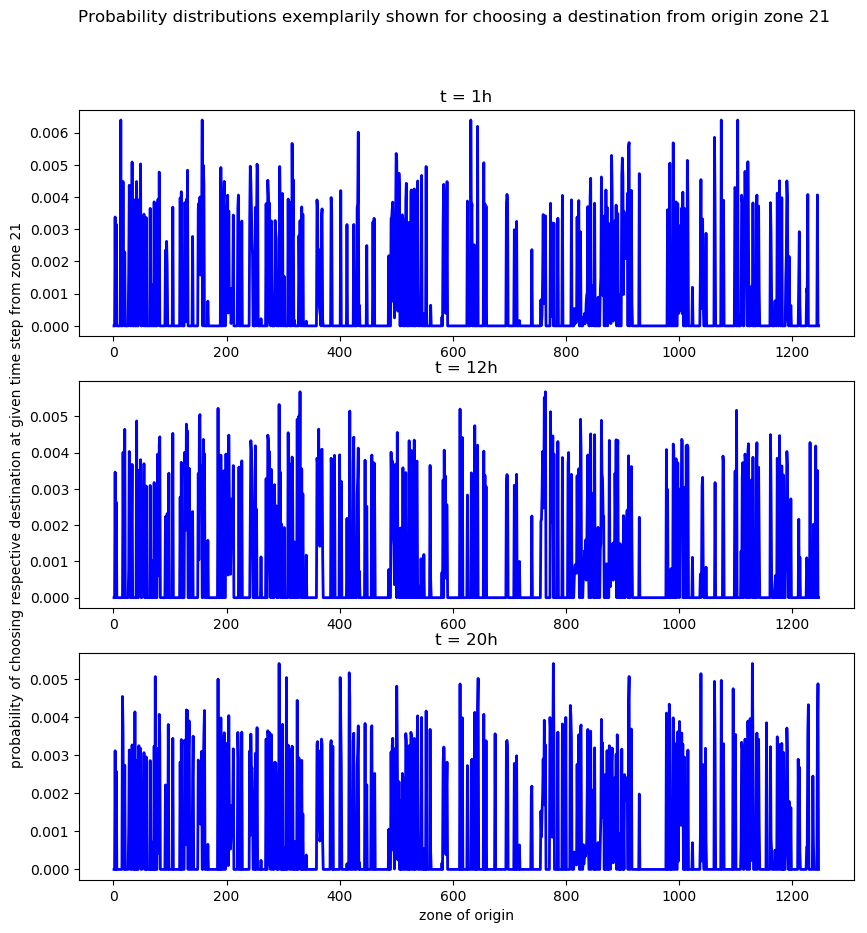

In [8]:
p_dest = zeros(number_zones, number_zones, T);
max_x = zeros(number_zones, number_zones);
min_x = zeros(number_zones, number_zones);
normalization_factor = zeros(number_zones, T);

e = 1; # An exponent that determines the dynamics of destination popularity. Can be changed.

# Calculating the minima and maxima of mean travel time 
for i=1:number_zones 
    # Calculating the minima and maxima
    for j=1:number_zones # destination zone ID
        max_x[i,j] = maximum(datamatrix[i, j, :, 1])
        min_x[i,j] = minimum(datamatrix[i, j, :, 1])
    end
end

# Calculating the unnormalized p_dest
for i=1:number_zones 
    for j=1:number_zones
        for t=1:T
            if (max_x[i, j] > 0)
                mean = datamatrix[i, j, t, 1];
                p_dest[i, j, t] = ((mean - min_x[i, j])/ (max_x[i, j] - min_x[i, j]))^e;
            end
        end
    end
end

# Calculating normalization factors
for i=1:number_zones
    for t=1:T
        normalization_factor[i, t] = sum(p_dest[i, :, t]);
    end
end

# Normalizing the probability distributions of p_dest
for i=1:number_zones 
    for t=1:T
        if(normalization_factor[i, t] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
            for j=1:number_zones
                p_dest[i, j, t] = p_dest[i, j, t] / normalization_factor[i, t];
            end
        end
    end
end

# Visualizing distribution for exemplar origin zone 21 and time steps 1h, 12h and 20h o'clock
x = 1:number_zones;
fig = figure(figsize=(10,10))

subplot(311)
y = p_dest[21,:, 1];
plot(x, y, color="blue", linewidth=2.0);
title("t = 1h");

subplot(312)
y = p_dest[21,:, 12];
plot(x, y, color="blue", linewidth=2.0);
ylabel("probability of choosing respective destination at given time step from zone 21");
title("t = 12h");

subplot(313)
y = p_dest[21,:, 20];
plot(x, y, color="blue", linewidth=2.0);
title("t = 20h");

suptitle("Probability distributions exemplarily shown for choosing a destination from origin zone 21");
xlabel("zone of origin");


---

## 4 Sampling
In this section, we use the stochastic distributions from above to sample the traffic behaviour of individual cars. The sampling process is all about filling two matrices with the information we want to model with respect to the sate and state transitions of the system. We call these matrices **"state_matrix"** and **"transition_matrix"**. We define the state of the system as the location zone of each car. The state transition is then defined as the traffic of cars from one zone to another and the travel time and distance that is associated with each trip. In the following subsections, we explain how we fill these matrices stepwise with the information we are interested in. Modelers can add or remove sampling steps for customizing the state and state transition properties of the system.




### 4.1 Initializing the state

In order to make generally applicable statements about temporal and spatial distributions of vehicles, one can model a constant number of cars, let us say 1,000, per zone as the entire vehicle fleet. For Boston, this would give a total fleet of C = 1,247,000 vehicles and allows us to make statements about the relative distribution of the total fleet among the zones of a city if this is what interests us the most. In order to have a starting point for the simulation, we uniformly distribute the total number of cars on all zones of the city. This is later improved by a treatment as an Initial Value Problem. 

In [9]:
C = 1247000;
C = trunc(Int, C); # transforms C from type Float64 to Integer. Necessary for subsequent matrix definitions. 
state_matrix = zeros(C, T); # C X T  matrix for saving states of the system, i.e. the location of cars in each timestep. The rows stand for car ID and the columns for the timestep.
transition_matrix = zeros(C, T, 4); # C X T X 4 matrix for saving state transitions of the system in each timestep. The entries for each car ID (C) and each time step (T) are the driving activity, destination, travel time and travel distance.
zone = 0;

# assigning a zone uniformely to each car
for i = 0:1000:(C-1000)
    zone = zone + 1;
    for j=1:1000
        state_matrix[i+j, 1] = zone; # each car receives a location zone in time step 1, i.e. at 1h o'clock 
    end  
end
state_matrix = round.(Int, state_matrix);
state_matrix # printing out state matrix with initial state in time step 1.


1247000×24 Array{Int64,2}:
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### 4.2 Sampling if a car drives
We use the entries of p_drive to decide whether a car drives or parks, given the time of the day and the location zone of a car. We demonstrate here, how excecuting this simulation step will fill the transition matrix if a car does not drive. In case that a car drives, we will need to choose a destination too; this happens in the next sampling step. 


In [10]:
for i=1:C
    origin = state_matrix[i,1];
    RndVar = rand();
    driving_probability = p_drive[origin,1];
    if(RndVar <= driving_probability)
        drive = 1;
    else
        drive = 0;
        transition_matrix[i,1,2]= origin;
    end
    transition_matrix[i,1,1] = drive;
end

### 4.3 Sampling travel destinations
The transition matrix is now filled for cars that do not drive. Here, we also fill the transition matrix for the cases in which a car was chosen to drive to another destination. The destination is chosen from the stochastic distributions of p_dest.

In [11]:
for i=1:C
    drive = transition_matrix[i,1,1];
    if (drive == 1)
        RndVar = rand();
        range_up = 0;
        range_low = 0;
        destination = 0; 
        origin = state_matrix[i,1];
        distribution = p_dest[origin, :, 1];
        if(sum(distribution) == 0) # this is the case that datamatrix has sparsity for the given origin zone
            destination = origin;
        else
            for j=1:number_zones  
                range_up = range_up + distribution[j];
                if(range_low < RndVar <= range_up)
                    destination = j;
                    break;
                end
                range_low = range_up;
            end
        end
        transition_matrix[i,1,2]= destination;
    end
end

### 4.4 Sampling travel durations
A stochastic distribution for sampling travel times can be derived directly from the mean and standard deviation of travel times between zones given by our original dataset. We assume a Gaussian/Normal distribution for sampling as it turns out that many random processes occurring in nature reveal this type of distribution.

In [12]:
for i=1:C
    origin = state_matrix[i,1,1];
    destination = round.(Int, transition_matrix[i,1,2]); # must turn this into integer variable for comparison
    if (origin != destination)
        mean = datamatrix[origin, destination, 1, 1];
        std_deviation = datamatrix[origin, destination, 1, 2];
        if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
            std_deviation = 0.1 * mean;
        end
        travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel time chosen from truncated normal distribution 
        transition_matrix[i,1,3] = travel_time;
    end
end

### 4.5 Sampling travel distances
In section 2, we determined a matrix called "distance_matrix_km". The entries of "distance_matrix_km" include the distance between each zone of the city. Here, we sample travel distances from a truncated normal distribution by taking the constant distance between the origin and destination zone as mean and a standard deviation of 10 percent of the mean. 

In [13]:
for i=1:C
    origin = state_matrix[i,1,1];
    destination = round.(Int, transition_matrix[i,1,2]);
    if (origin != destination)
        mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
        std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
        travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel distance chosen from truncated normal distribution.
        transition_matrix[i,1,4] = travel_distance; 
    end
end

### 4.6 State update
Afer we have determined the transition matrix, we can update the state matrix. The state matrix in any time step t+1 is equal to the transition matrix entries at time step t.

In [14]:
state_matrix[:,2] = transition_matrix[:,1,2];
state_matrix # to show the matrix

1247000×24 Array{Int64,2}:
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    1     1  0  0  0  0  0  0  0  0  

### 4.7 Initial Value Problem
An uniform distribution of cars over all zones of the city as the initial state of the traffic system is not a realistic assumption. Hence, we are looking for a more realistic system state to start with. In state estimation tasks this is known as the Initial Value Problem. We solve the Initial Value Problem here by assuming the state after T = 24 simulation steps as the initial state of the system, i.e. after a large share of the stochastic distributions came to application. The idea behind this approach is that we expect the spatial distribution of the vehicles to naturally shape and approach a more realistic scenario. This is visualized below. Note that this is a computationally intensive step.

4% of the Initial Value Problem is solved
8% of the Initial Value Problem is solved
13% of the Initial Value Problem is solved
17% of the Initial Value Problem is solved
21% of the Initial Value Problem is solved
26% of the Initial Value Problem is solved
30% of the Initial Value Problem is solved
34% of the Initial Value Problem is solved
39% of the Initial Value Problem is solved
43% of the Initial Value Problem is solved
47% of the Initial Value Problem is solved
52% of the Initial Value Problem is solved
56% of the Initial Value Problem is solved
60% of the Initial Value Problem is solved
65% of the Initial Value Problem is solved
69% of the Initial Value Problem is solved
73% of the Initial Value Problem is solved
78% of the Initial Value Problem is solved
82% of the Initial Value Problem is solved
86% of the Initial Value Problem is solved
91% of the Initial Value Problem is solved
95% of the Initial Value Problem is solved


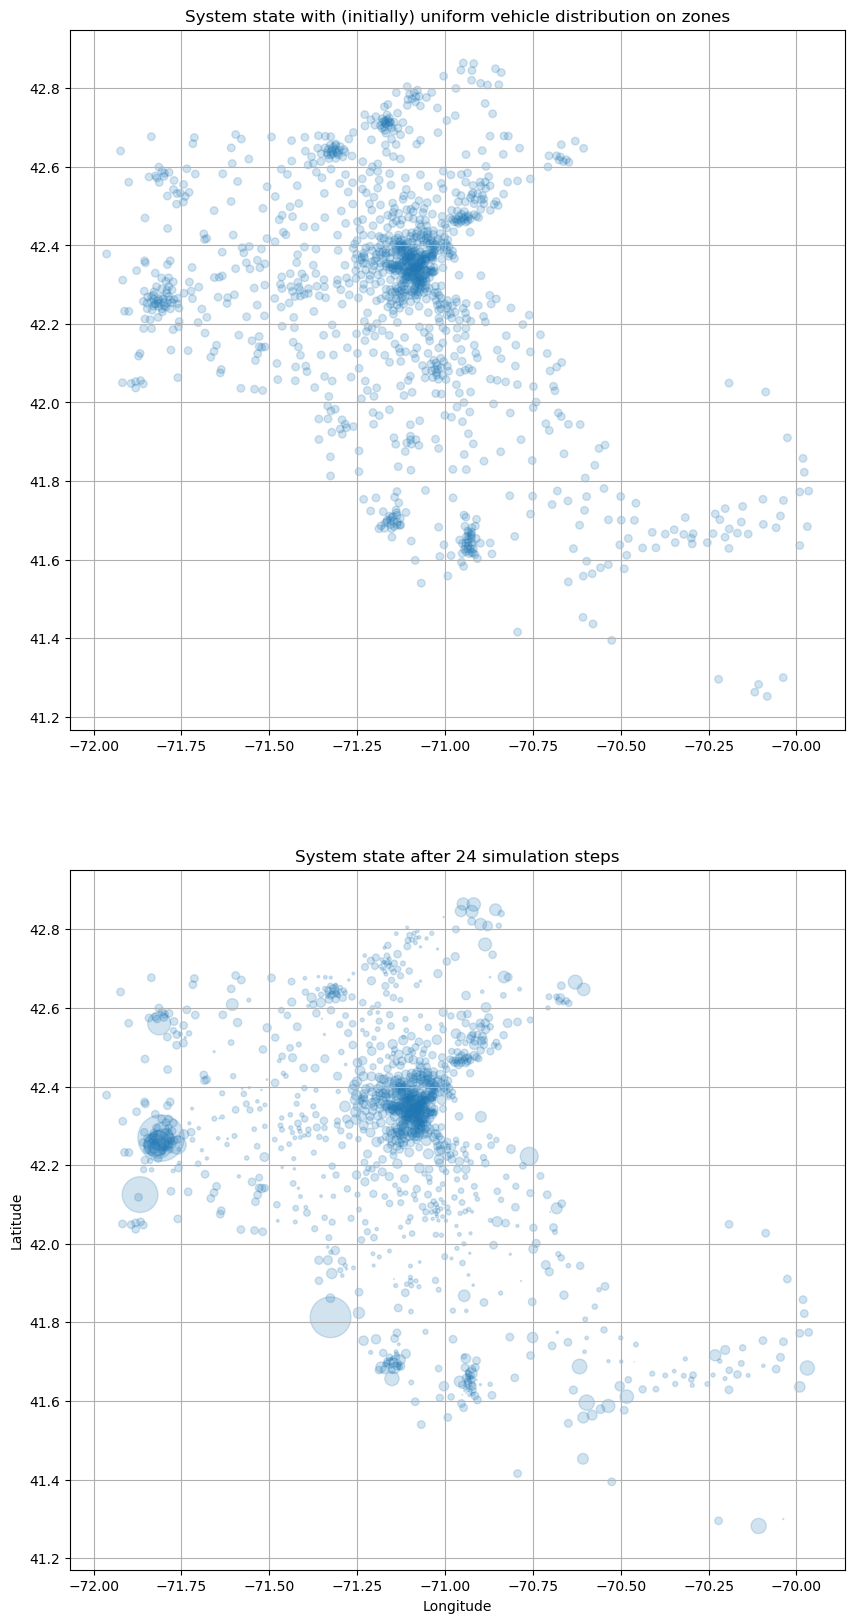

100% of the Initial Value Problem is solved


In [15]:
initial_state = zeros(C,1);


for t=1:(T-1)
    
    # Sampling if a car drives
    for i=1:C
        origin = state_matrix[i,t];
        RndVar = rand();
        driving_probability = p_drive[origin,t];
        if(RndVar <= driving_probability)
            drive = 1;
        else
            drive = 0;
            transition_matrix[i,t,2]= origin;
        end
        transition_matrix[i,t,1] = drive;
    end
    
    
    # Sampling travel destinations
    for i=1:C
        drive = transition_matrix[i,t,1];
        if (drive == 1)
            RndVar = rand();
            range_up = 0;
            range_low = 0;
            destination = 0;
            origin = state_matrix[i,t];
            distribution = p_dest[origin, :, t];
            if(sum(distribution) == 0)
                destination = origin;
            else
                for j=1:number_zones  
                    range_up = range_up + distribution[j];
                    if(range_low < RndVar <= range_up)
                        destination = j;
                        break;
                    end
                    range_low = range_up;
                end
            end
            transition_matrix[i,t,2] = destination;
        end
    end

    
    # state update
    state_matrix[:,t+1] = transition_matrix[:,t,2];
    println(trunc(Int,t/0.23),"% of the Initial Value Problem is solved")
end

initial_state = state_matrix[:,24];
initial_state = round.(Int, initial_state)

#visualizing results
zone = zeros(number_zones,T);
for i=1:C
    for t=1:T
        index = state_matrix[i,t]
        zone[index,t] = zone[index,t] + 1;
    end
end

x = average_long;
y = average_lat;
fig = figure(figsize=(10,20))

subplot(211);
areas = zone[:,1] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state with (initially) uniform vehicle distribution on zones");
grid("on");

subplot(212);
areas = zone[:,24] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state after 24 simulation steps");
grid("on");

xlabel("Longitude");
ylabel("Latitude");


### 4.8 Resampling
If we simply continue the sampling process for conscutive days, we will reach a saturated state where all cars gather in one or few city zones. Resampling allows us to avoid this and replicate one sample per dataset for the simulation of multiple consecutive days/weeks/months/years. We simulate periodic commuting behaviour, meaning that cars end up at their initial state at the end of the day. Hence, in the last simulation step of a day, i.e. around midnight, we assume that vehicles return to their original zone if they are not there already. Simulating a consecutive day hence becomes straightforward: determining the transition matrix according to this for the last simulation step T gives a smooth transition to the next day with the same sampling results. Note that the arising error of this is smaller for a Macroscopic traffic flow analysis than for a Microscopic one. 

4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% of the dataset is simulated
26% of the dataset is simulated
30% of the dataset is simulated
34% of the dataset is simulated
39% of the dataset is simulated
43% of the dataset is simulated
47% of the dataset is simulated
52% of the dataset is simulated
56% of the dataset is simulated
60% of the dataset is simulated
65% of the dataset is simulated
69% of the dataset is simulated
73% of the dataset is simulated
78% of the dataset is simulated
82% of the dataset is simulated
86% of the dataset is simulated
91% of the dataset is simulated
95% of the dataset is simulated


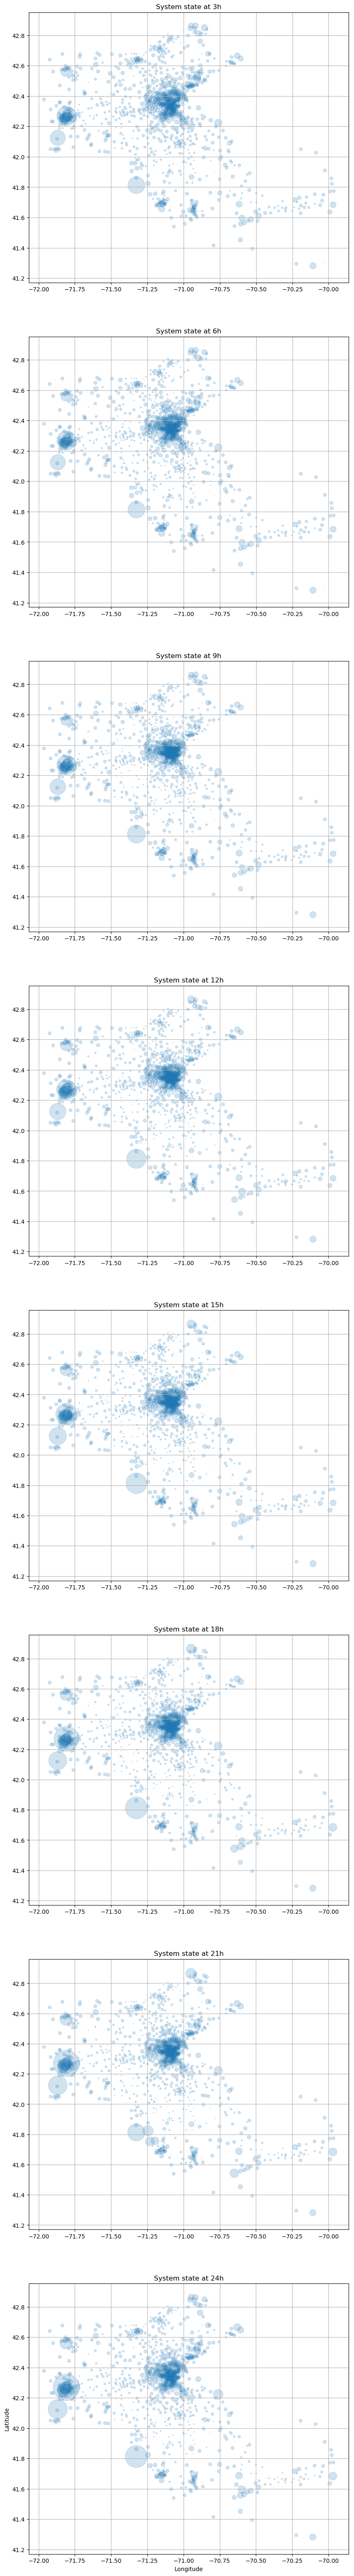

100% of the dataset is simulated


In [16]:
# Initial Value Problem: assume the state after 24 simulation steps as the initial state of the system
state_matrix[:,1] = initial_state; 

# simulate an entire day with improved initial value
for t=1:(T-1)
    
    # Sampling if a car drives
    for i=1:C
        origin = state_matrix[i,t];
        RndVar = rand();
        driving_probability = p_drive[origin,t];
        if(RndVar <= driving_probability)
            drive = 1;
        else
            drive = 0;
            transition_matrix[i,t,2]= origin;
        end
        transition_matrix[i,t,1] = drive;
    end
    
    
    
    # Sampling travel destinations
    for i=1:C
        drive = transition_matrix[i,t,1];
        if (drive == 1)
            RndVar = rand();
            range_up = 0;
            range_low = 0;
            destination = 0;
            origin = state_matrix[i,t];
            distribution = p_dest[origin, :, t];
            if(sum(distribution) == 0)
                destination = origin;
            else
                for j=1:number_zones  
                    range_up = range_up + distribution[j];
                    if(range_low < RndVar <= range_up)
                        destination = j;
                        break;
                    end
                    range_low = range_up;
                end
            end
            transition_matrix[i,t,2]= destination;
        end
    end
    
    
    
    # sampling travel times and distances 
    for i=1:C
        drive = transition_matrix[i,t,1];
        if(drive == 1)
            origin = state_matrix[i,t,1];
            destination = round.(Int, transition_matrix[i,t,2]);
            if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
            else
                # sampling travel times
                mean = datamatrix[origin, destination, t, 1];
                std_deviation = datamatrix[origin, destination, t, 2];
                if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                    std_deviation = 0.1 * mean;
                end
                travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                transition_matrix[i,t,3] = travel_time;

                # sampling travel distances
                mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                transition_matrix[i,t,4] = travel_distance;
            end
        end
    end

    # state update
    state_matrix[:,t+1] = transition_matrix[:,t,2];
    println(trunc(Int,t/0.23),"% of the dataset is simulated")
end


# continue sampling period with smooth transition to next day by resetting car locations
for i=1:C
    origin = state_matrix[i,1];
    destination = state_matrix[i,T];
    if(origin == destination)
        transition_matrix[i,T,1] = 0;
        transition_matrix[i,T,2] = origin;
    else
        transition_matrix[i,T,1] = 1;
        transition_matrix[i,T,2] = origin;
        travel_time = datamatrix[origin, destination, T, 1];
        travel_distance = distance_matrix_km[origin, destination];
        if(travel_time == 0) # this is the case that the original dataset does not contain this connection
            transition_matrix[i,T,3] = travel_distance / 60; # this assumes an average driving velocity of 60km/h.
        else
            transition_matrix[i,T,3] = travel_time; # this assumes the mean travel time directly without sampling. Can also be sampled.
        end
        transition_matrix[i,T,4] = travel_distance; # this assumes the zone distance directly without sampling. Can also be sampled.
    end
end


#visualizing results
zone = zeros(number_zones,T);
for i=1:C
    for t=1:T
        index = state_matrix[i,t]
        zone[index,t] = zone[index,t] + 1;
    end
end
x = average_long;
y = average_lat;
fig = figure(figsize=(10,80))

subplot(811);
areas = zone[:,3] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 3h");
grid("on");

subplot(812);
areas = zone[:,6] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 6h");
grid("on");

subplot(813);
areas = zone[:,9] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 9h");
grid("on");

subplot(814);
areas = zone[:,12] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 12h");
grid("on");

subplot(815);
areas = zone[:,15] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 15h");
grid("on");

subplot(816);
areas = zone[:,18] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 18h");
grid("on");

subplot(817);
areas = zone[:,21] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 21h");
grid("on");

subplot(818);
areas = zone[:,24] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 24h");
grid("on");

xlabel("Longitude");
ylabel("Latitude");


---

## 5 Normalizing
The parameters p_min and p_max determine the range of probabilities according to which we decide whether a car drives or parks given the time of the day and the location zone; they were initially set to 0.1 and 0.9 respectively. These initial values were chosen arbitrarily and therefore include a source of error. In order to improve their values and achieve a more realistic sample, we introduce:
* A<sub>set</sub> := the realistic amount of driving time within the lifetime of a vehicle.
* A<sub>drive</sub> := the sampled amount of driving time within the lifetime of a vehicle.

If we assume that cars are parked around 95% of the time in the United States, then the realistic setpoint value to which we want to approach the relative driving time per day in our sampling is  A<sub>set</sub>=0.05. Other possible set point values for normalizing the traffic system could be the number of sampled trips and or the average travel distance. In section 5.1 we calculate the average driving time before normalizing; in section 5.2 we introduce a numeric iterative algorithm which then improves the values of p_min and p_max.

### 5.1 Unnormalized traffic system
We calculate the average driving time per day of all cars from the travel time entries of the transition matrix. The value of interest which we need to change by tuning the distribution parameters minpar and maxpar is A<sub>drive</sub> = 0.09. 

In [17]:
sum_driving_time = 0;
driving_time_entries = zeros(C,1);

for t=1:T
    driving_time_entries = transition_matrix[:,t,3];
    sum_driving_time = sum_driving_time + sum(driving_time_entries);
end
driving_share_in_lifetime = sum_driving_time/(C * T * 60 * 60); # travel times are recorded in seconds.
println("Without normalization, the simulated cars drive around ",trunc(Int,driving_share_in_lifetime * 100),"% of their lifetime.")

Without normalization, the simulated cars drive around 9% of their lifetime.


### 5.2 Normalizing traffic system
From the step above we receive an average driving time of around 9% (A<sub>drive</sub>=0.09). For the tuning parameters this means that p_max has to be decremented stepwise so as to approach the setpoint value of A<sub>set</sub>=0.05. We do this iteratively and - for the sake of computational time - terminate the algorithm after a fixed number of iterations "max_iteration", or after reaching a good enough result. A flow chart of a generally applicable algorithm which covers all cases can be seen below. The algorithm can be divided into six steps; each step is indicated in the chart. 

First, we initialize the step number n and determine a setpoint value A<sub>set</sub>. For this, we assume that cars are parked around 95% of the time in the United States. Second, we do a complete sampling. These are all steps after solving the Initial Value Problem we introduced in the previous section. If we sample from data of an entire year or of several years, the normalization would also consider intra- and interannual fluctuations of driving times. Third, we calculate the driving time of the respective normalization step from the transition matrix entries. Further, we calculate the difference of sampled driving time to the setpoint value as △A<sub>n</sub>. Fourth, we check if we have reached the maximum number of iterations so as to terminate. In case we did not, we further check if the current parameter values for par_min<sub>n</sub> and par_max<sub>n</sub> deliver better results than those from the last sampling, i.e. if |△A<sub>n</sub>| < |△A<sub>n-1</sub>|, and keep these if this is so; if this is not the case, we will reset the values to those of the last step p_min<sub>n-1</sub> and p_max<sub>n-1</sub>. Fifth, we check if the values of p_min<sub>n</sub> and p_max<sub>n</sub> have reached their bounds. The presented algorithm first tunes p_max, and only after reaching an edge it changes to tuning p_min on top; whether we do it this way or the other way around does not play an important role. An edge is reached if for instance A<sub>drive,n</sub> needs to be increased so as to approach A<sub>set</sub>, and p_max<sub>n</sub> has already assumed its maximum value of 1; then, an increase of A<sub>drive,n</sub> must be achieved by increasing p_min<sub>n</sub>. Depending on which parameter we chose to tune, one of the two equations in the large blocks of step 5 are solved. Sixth and last, we check if the new p_min or p_max values cross any bounds and increment the step enumeration by one. The loop closes back on a complete sampling with the new values for p_min and p_max. 

Generally, anything else than travel time can be used as set point value for normalization. Suitable values could be the number of trips, or the average travel distance. Modelers can use as set point values what is most relevant in their research, or what is simply available.
<img src="Figures/NormalizingAlgorithmFlowChart.png">

In [18]:
###Step 1: defining setpoint value, maximum number of iterations and initial minpar and maxpar values.
A_set = 0.05;
N = 1; 
△A = 0;
max_iteration = 6;
e = 1; 
p_min = zeros(max_iteration,1);
p_max = zeros(max_iteration,1);
A_drive = zeros(max_iteration,1);
p_min[1] = 0.1;
p_max[1] = 0.9;


while N<max_iteration
    
    ###Step 2: starting sampling loop. The first iteration is just the same as the entire sampling procedure above, without solving the initial value problem.
    # determining weather a car drives or parks
    p_drive = zeros(number_zones, T);
    mean_sum = zeros(number_zones, T);
    min_t = zeros(number_zones,1);
    max_t = zeros(number_zones,1);
    println("Simulating at iteration n = ",N)
    
    # Calculating the sums, minimum sums and maximum sums of mean travel time out of a zone
    for i=1:number_zones    
        for t=1:T
            mean_sum[i, t] = sum(datamatrix[i,:,t,1]); # here you can erase or vary the exponent.
        end
        max_t[i] = maximum(mean_sum[i,:]);
        min_t[i] = minimum(mean_sum[i,:]);
    end

    # Calculating the Bernoulli distributions p_drive
    for i=1:number_zones
        if(max_t[i] > 0) # A zero would lead to infinity given the formula below and create NaN entries.
            for t=1:T
                # A linear function for assigning a value of 10% to p_drive if min_t is given, and a value of 90% if max_t is given.
                p_drive[i,t] = p_min[N] + (p_max[N] - p_min[N]) * ((mean_sum[i,t] - min_t[i]) / (max_t[i] - min_t[i]))^e;  
            end
        end
    end
    
    
    # Initial Value Problem: assume the state after 24 simulation steps as the initial state of the system
    state_matrix = zeros(C, T); # C X T  matrix for saving states of the system, i.e. the location of cars in each timestep. The rows stand for car ID and the columns for the timestep.
    transition_matrix = zeros(C, T, 4); # C X T X 4 matrix for saving state transitions of the system in each timestep. The entries for each car ID (C) and each time step (T) are the binary Drive or Park, the location of destination, travel 
    state_matrix = round.(Int, state_matrix);
    state_matrix[:,1] = initial_state;
    
    # simulate an entire day with improved initial value
    for t=1:(T-1)

        # Sampling if a car drives
        for i=1:C
            origin = state_matrix[i,t];
            RndVar = rand();
            driving_probability = p_drive[origin,t];
            if(RndVar <= driving_probability)
                drive = 1;
            else
                drive = 0;
                transition_matrix[i,t,2]= origin;
            end
            transition_matrix[i,t,1] = drive;
        end

        # Sampling travel destinations
        for i=1:C
            drive = transition_matrix[i,t,1];
            if (drive == 1)
                RndVar = rand();
                range_up = 0;
                range_low = 0;
                destination = 0;
                origin = state_matrix[i,t];
                distribution = p_dest[origin, :, t];
                if(sum(distribution) == 0)
                    destination = origin;
                else
                    for j=1:number_zones  
                        range_up = range_up + distribution[j];
                        if(range_low < RndVar <= range_up)
                            destination = j;
                            break;
                        end
                        range_low = range_up;
                    end
                end
                transition_matrix[i,t,2]= destination;
            end
        end
        
        # sampling travel times and distances 
        for i=1:C
            drive = transition_matrix[i,t,1];
            if(drive == 1)
                origin = state_matrix[i,t,1];
                destination = round.(Int, transition_matrix[i,t,2]);
                if(origin == destination) # this is the case that a car drives to a destination within the origin zone
                    transition_matrix[i,t,3] = 5 * 60; # assuming arbitrarily a driving time of 5 minutes given in seconds
                    transition_matrix[i,t,4] = 1; # assuming arbitraliy a driving distance of 1 km given in km. 
                else
                    # sampling travel times
                    mean = datamatrix[origin, destination, t, 1];
                    std_deviation = datamatrix[origin, destination, t, 2];
                    if(std_deviation == 0) # catches the case of missing std deviation data where it is set to 0 in the original datasets
                        std_deviation = 0.1 * mean;
                    end
                    travel_time = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1* mean)); # travel time chosen from truncated normal distribution 
                    transition_matrix[i,t,3] = travel_time;

                    # sampling travel distances
                    mean = distance_matrix_km[origin, destination]; # constant zone distances as mean
                    std_deviation = mean * 0.1; # arbitrary chosen standard deviation as 10% of the mean value, to create some variation.  
                    travel_distance = rand(Truncated(Normal(mean, std_deviation),0.9 * mean, 1.1 * mean)); # travel distance chosen from truncated normal distribution.
                    transition_matrix[i,t,4] = travel_distance;
                end
            end
        end
        
        # state update
        state_matrix[:,t+1] = transition_matrix[:,t,2];
        println(trunc(Int,t/0.23),"% of the dataset is simulated")
    end

    # continue sampling period with smooth transition to next day by resetting car locations
    for i=1:C
        origin = state_matrix[i,1];
        destination = state_matrix[i,T];
        if(origin == destination)
            transition_matrix[i,T,1] = 0;
            transition_matrix[i,T,2] = origin;
        else
            transition_matrix[i,T,1] = 1;
            transition_matrix[i,T,2] = origin;
            travel_time = datamatrix[origin, destination, T, 1];
            travel_distance = distance_matrix_km[origin, destination];
            if(travel_time == 0) # this is the case that the original dataset does not contain this connection
                transition_matrix[i,T,3] = travel_distance / 60; # this assumes an average driving velocity of 60km/h.
            else
                transition_matrix[i,T,3] = travel_time; # this assumes the mean travel time directly without sampling. Can also be sampled.
            end
            transition_matrix[i,T,4] = travel_distance; # this assumes the zone distance directly without sampling. Can also be sampled.
        end
    end
    
    
    ###Step 3: calculating A_drive and △A 
    sum_driving_time = 0;
    driving_time_entries = zeros(C,1);
    for t=1:T
        driving_time_entries = transition_matrix[:,t,3];
        sum_driving_time = sum_driving_time + sum(driving_time_entries);
    end
    A_drive[N] = sum_driving_time/(C * T * 60 * 60);
    △A = A_set - A_drive[N];
    println("The simulated vehicles drive around ",trunc(Int, A_drive[N] * 100),"% of their lifetime. This gives a △A = ",△A," at iteration n = ",N)
    
    
    
    ###Step 4: checking if solution is improved and resetting parameter values if this is not the case.
    if(trunc(Int,A_set * 100) == trunc(Int,A_drive[N] * 100))
        println("A good solution is found for p_min = ",p_min[N]," and p_max = ",p_max[N]);
        break
    end
    if(N>=2 && abs(△A) > abs(A_set - A_drive[N]))
        println("The parameters p_min = ",p_min[N]," and p_max = ",p_max[N]," lead to |△A| = ",abs(△A),". This is worse than the last solution so we reset the parameters to p_min = ",p_min[N-1]," and p_max = ",p_max[N-1]);
        p_min[N] = p_min[N-1];
        p_max[N] = p_max[N-1];
        △A = A_set - A_drive[N-1];
        A_drive[N] = A_drive[N-1];
    end
    
    
    
    ###Step 5: Choosing which equation to solve, depending on whether parameters reached bounds or not.
    if(p_max[N]==1)
        if(p_min[N]==p_max[N])
            println("something went wrong! p_min is equal to p_max!");
            break
        else
            p_min[N+1] = p_min[N] + (p_max[N] + p_min[N]) * △A / (N * A_drive[N]);
            p_max[N+1] = p_max[N];
        end
    else
        if(p_min[N]==0)
            if(p_min[N]==p_max[N])
                println("something went wrong! p_min is equal to p_max!");
                break
            else
                p_max[N+1] = p_max[N] + (p_max[N] + p_min[N]) * △A / (N * A_drive[N]);
                p_min[N+1] = p_min[N];
            end
        else
            if(p_min[N]==p_max[N])
                p_min[N+1] = p_min[N] + (p_max[N] + p_min[N]) * △A / (N * A_drive[N]);
                p_max[N+1] = p_max[N];
            else
                p_max[N+1] = p_max[N] + (p_max[N] + p_min[N]) * △A / (N * A_drive[N]);
                p_min[N+1] = p_min[N];
            end
        end
    end
    
    
    
    ###Step 6: correcting new parameters in case they cross any feasible bounds. 
    if(p_min[N+1]<0)
        p_min[N+1] = 0;
    else
        if(p_min[N+1]>p_max[N])
            p_min[N+1] = p_max[N];
        end
    end
    if(p_max[N+1]>1)
        p_max[N+1] = 1;
    else
        if(p_max[N+1]<p_min[N])
            p_max[N+1] = p_min[N];
        end
    end
    N = N + 1;
end

if(N == max_iteration)
    println("Maximum number of iterations is reached. Best found solution is p_min = ",p_min[N]," and p_max = ",p_max[N])
end

Simulating at iteration n = 1
4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simulated
17% of the dataset is simulated
21% of the dataset is simulated
26% of the dataset is simulated
30% of the dataset is simulated
34% of the dataset is simulated
39% of the dataset is simulated
43% of the dataset is simulated
47% of the dataset is simulated
52% of the dataset is simulated
56% of the dataset is simulated
60% of the dataset is simulated
65% of the dataset is simulated
69% of the dataset is simulated
73% of the dataset is simulated
78% of the dataset is simulated
82% of the dataset is simulated
86% of the dataset is simulated
91% of the dataset is simulated
95% of the dataset is simulated
100% of the dataset is simulated
The simulated vehicles drive around 9% of their lifetime. This gives a △A = -0.04052140306119298 at iteration n = 1
Simulating at iteration n = 2
4% of the dataset is simulated
8% of the dataset is simulated
13% of the dataset is simul

### 5.3 Normalizing results
Our final results are supposed to be the geospatial distribution of cars for each time step we simulate. We normalize these distributions by dividing the number of cars in each zone by the total number of vehicles we chose to sample. We receive the percentage of vehicles present in each zone in each time step. These values can be scaled by the total number of cars which the modeler wants to sample. 

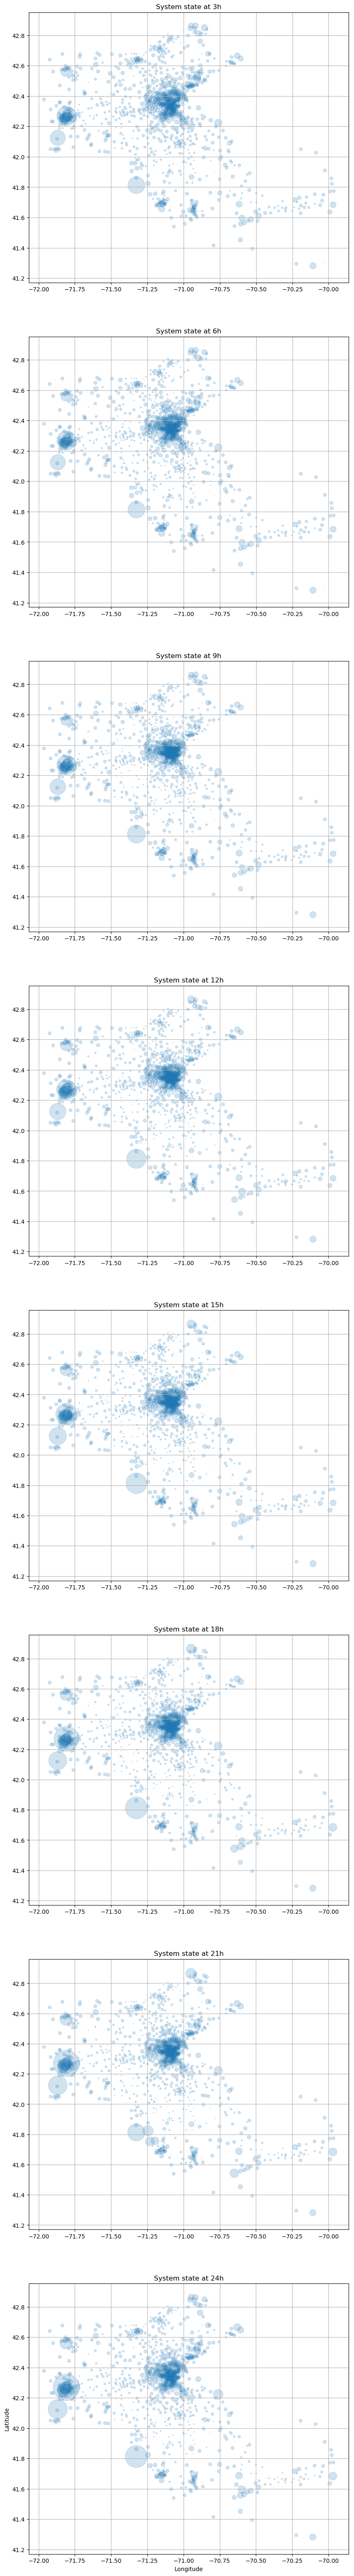

In [19]:
results = zeros(number_zones,T);

for i=1:C
    for t=1:T
        index = state_matrix[i,t]
        results[index,t] = results[index,t] + 1;
    end
end

results = results/C;

x = average_long;
y = average_lat;
fig = figure(figsize=(10,80))

subplot(811);
areas = zone[:,3] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 3h");
grid("on");

subplot(812);
areas = zone[:,6] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 6h");
grid("on");

subplot(813);
areas = zone[:,9] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 9h");
grid("on");

subplot(814);
areas = zone[:,12] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 12h");
grid("on");

subplot(815);
areas = zone[:,15] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 15h");
grid("on");

subplot(816);
areas = zone[:,18] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 18h");
grid("on");

subplot(817);
areas = zone[:,21] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 21h");
grid("on");

subplot(818);
areas = zone[:,24] * 0.03;
scatter(x,y,areas,alpha=0.2);
title("System state at 24h");
grid("on");

xlabel("Longitude");
ylabel("Latitude");


---